In [116]:
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error



import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch



import matplotlib.pyplot as plt
from pylab import rcParams
from IPython.display import display
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [117]:
ticker = yf.Ticker("NVDA")
print(ticker)
data = yf.download('NVDA', start='2015-01-01', end='2025-01-01')

data.head()


[*********************100%***********************]  1 of 1 completed

yfinance.Ticker object <NVDA>


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483144,0.486744,0.475463,0.483144,113680000
2015-01-05,0.474983,0.484584,0.472823,0.483143,197952000
2015-01-06,0.460582,0.476183,0.460102,0.475703,197764000
2015-01-07,0.459382,0.468023,0.457942,0.463943,321808000
2015-01-08,0.476663,0.479543,0.464423,0.464663,283780000


In [118]:
data.index = pd.to_datetime(data.index)  #data from yfinance provides a DatetimeIndex, but not automatically assign a frequency ( which what statsmodels expect)
data = data.asfreq('B')
print(data.index.freq)


<BusinessDay>


In [119]:
ticker.info['currency']

'USD'

In [120]:
print(data.isnull().sum())


Price   Ticker
Close   NVDA      92
High    NVDA      92
Low     NVDA      92
Open    NVDA      92
Volume  NVDA      92
dtype: int64


### Visualizing trends, seasonality, and volatility

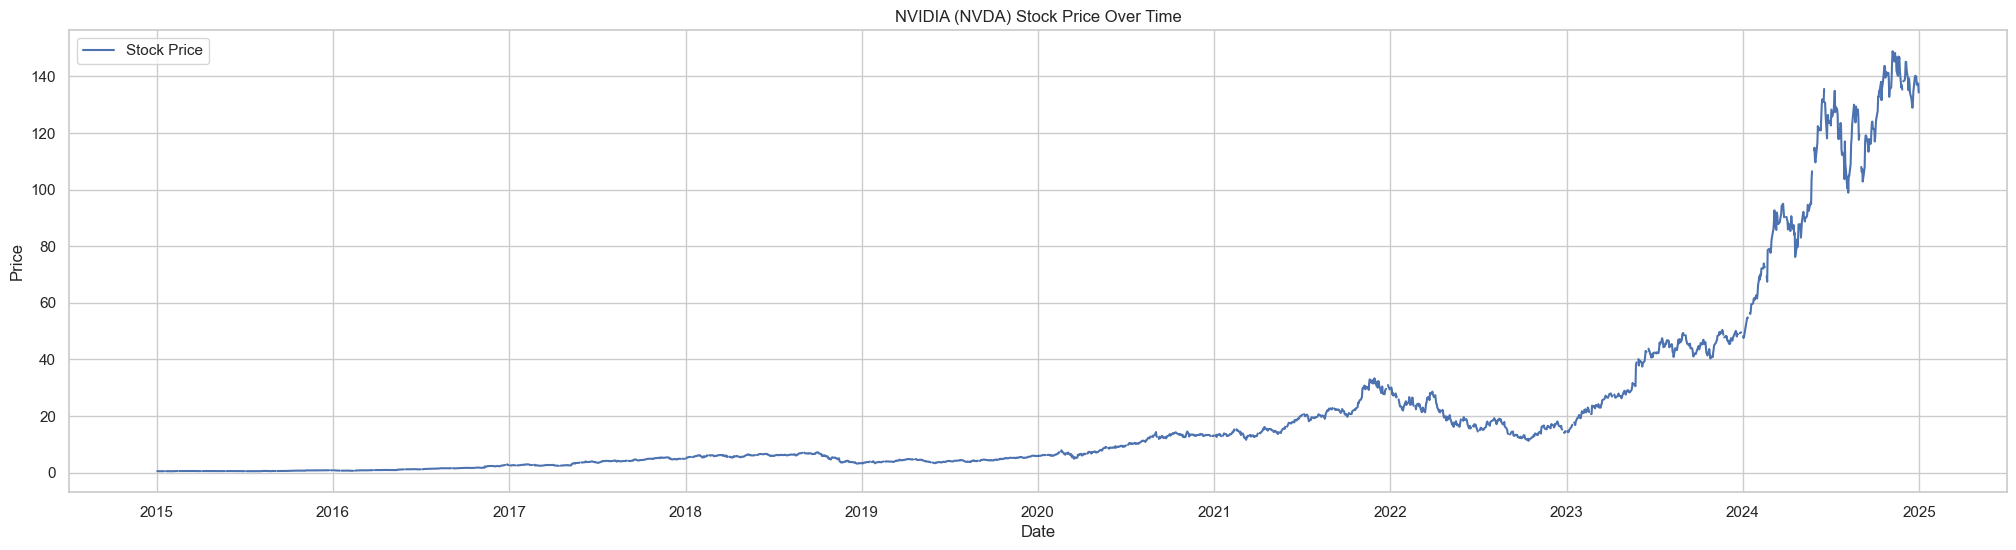

In [121]:
plt.figure(figsize=(25,6))
plt.plot(data['Close'], label='Stock Price')
plt.title('NVIDIA (NVDA) Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


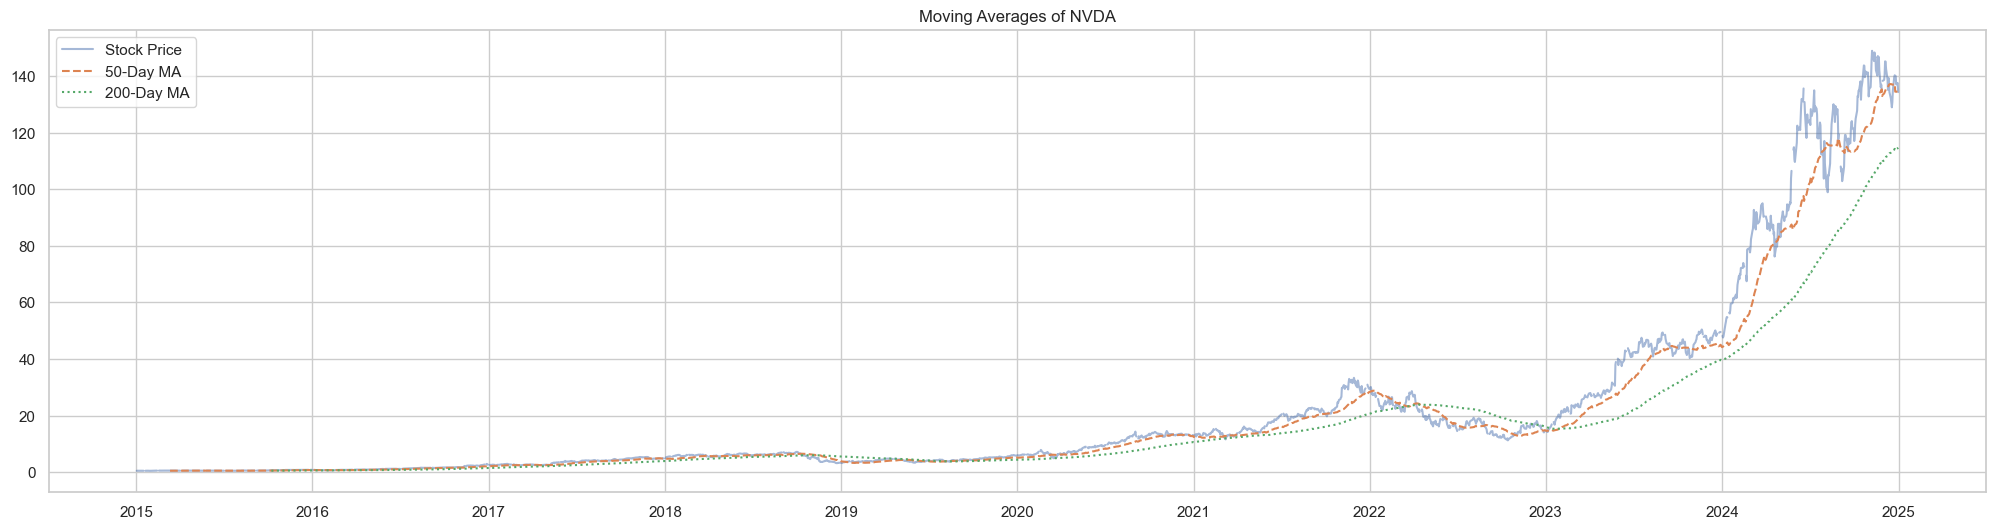

In [122]:
#trend smoothing
data_50_MA = data['Close'].fillna(0).rolling(window=50).mean()  # 50-day moving average
data_200_MA = data['Close'].fillna(0).rolling(window=200).mean()  # 200-day moving average

plt.figure(figsize=(25,6))
plt.plot(data['Close'], label='Stock Price', alpha=0.5)
plt.plot(data_50_MA, label='50-Day MA', linestyle='dashed')
plt.plot(data_200_MA, label='200-Day MA', linestyle='dotted')
plt.title('Moving Averages of NVDA')
plt.legend()
plt.show()


* upward momentum since 2023
* 50-day MA crossed above the 200-day MA (Golden Cross) -> bullish

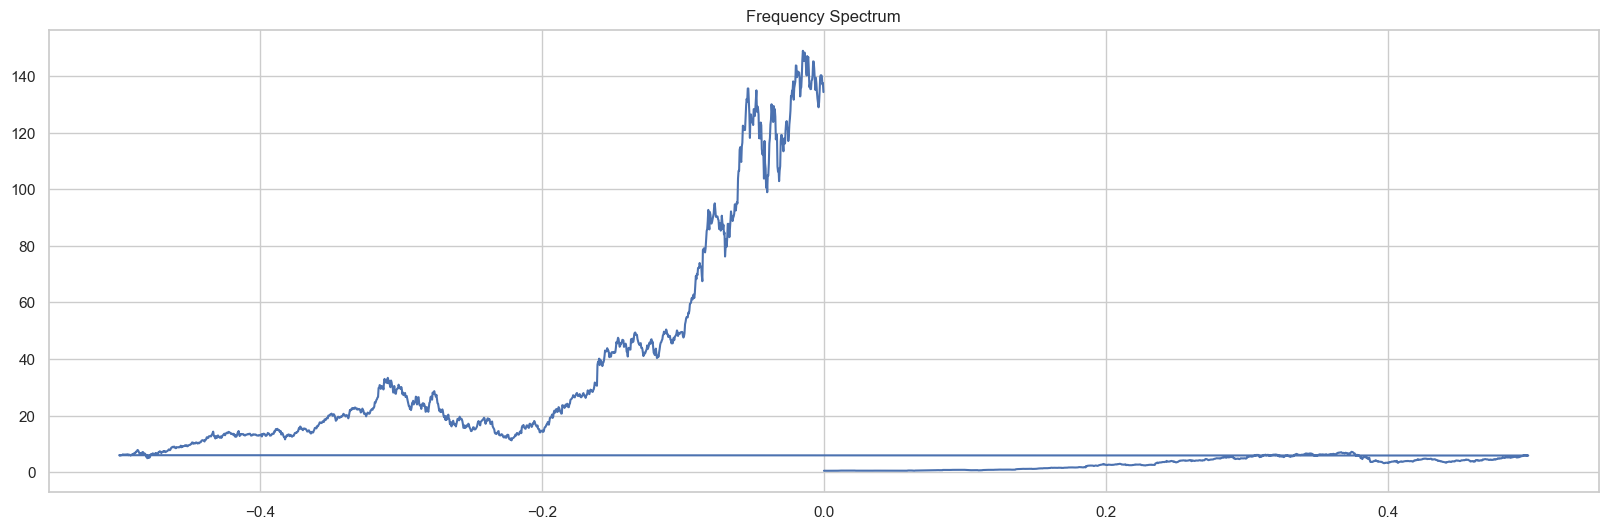

In [123]:
# Fourier Analysis to extract dominant frequencies that correspond to seasonal periods(amplitude en fonction de frequence..)

from scipy.fftpack import fft

fft_values = fft(data['Close'].fillna(method='ffill'))
frequencies = np.fft.fftfreq(len(fft_values))

#plot the spectrum
plt.figure(figsize=(20,6))
plt.plot(frequencies, np.abs(fft_values))
plt.title('Frequency Spectrum')
plt.show()

* highest peak in positive side is around feq = .004 &rarr; period = 1/.004 = 250  &rarr; 252 trading days in a year seems likely appropriate

In [124]:
data_monthly = data.reset_index()

data_monthly['Date'] = pd.to_datetime(data_monthly['Date'])

data_monthly = data_monthly.set_index('Date')

if 'Ticker' in data_monthly.columns:
    data_monthly = data_monthly.drop(columns=['Ticker'])

data_monthly.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483144,0.486744,0.475463,0.483144,113680000.0
2015-01-05,0.474983,0.484584,0.472823,0.483143,197952000.0
2015-01-06,0.460582,0.476183,0.460102,0.475703,197764000.0
2015-01-07,0.459382,0.468023,0.457942,0.463943,321808000.0
2015-01-08,0.476663,0.479543,0.464423,0.464663,283780000.0


<Axes: xlabel='Date'>

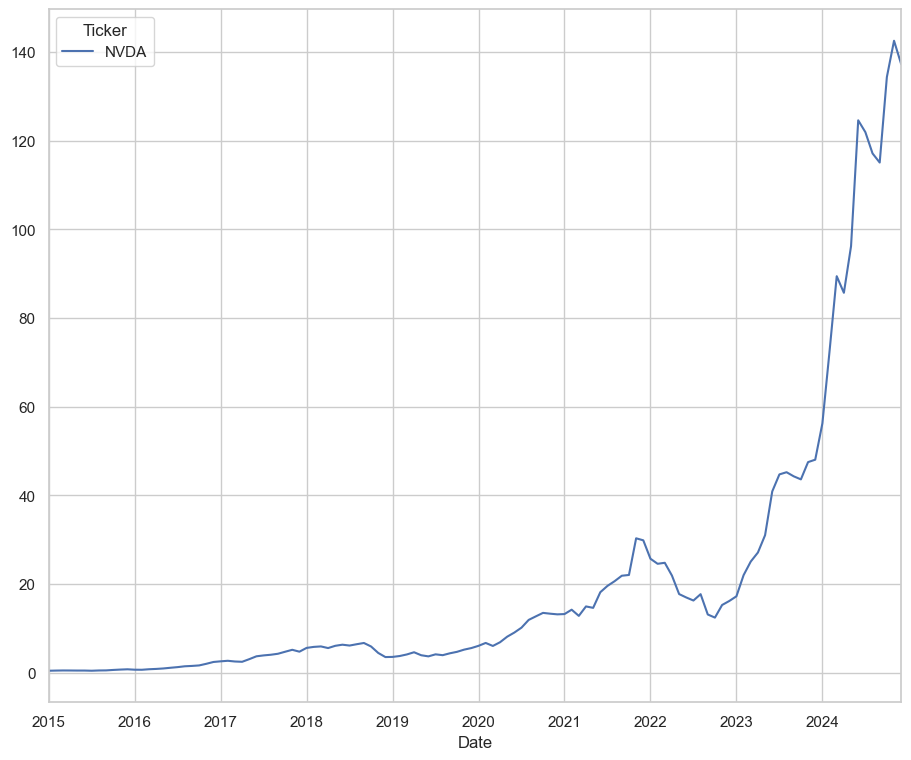

In [125]:
data_monthly= data.resample('M').mean()

data_monthly.Close.plot()

<function matplotlib.pyplot.show(close=None, block=None)>

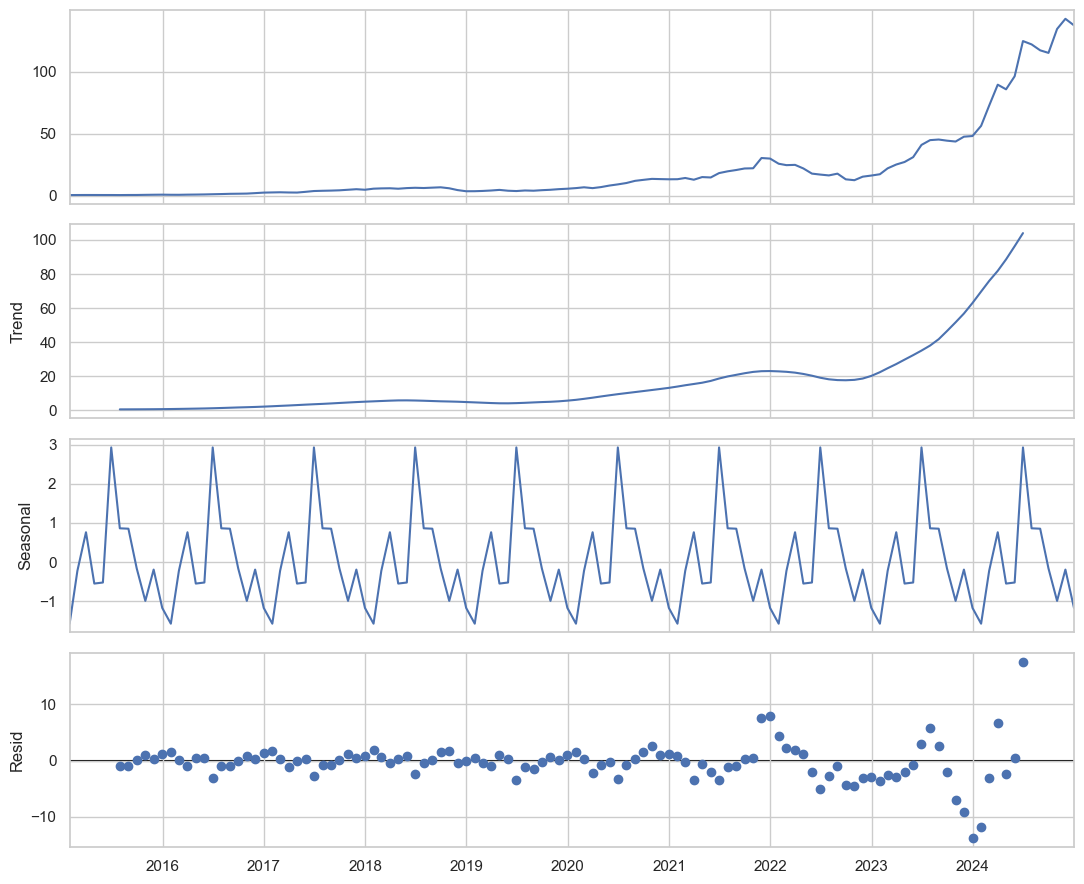

In [126]:

rcParams['figure.figsize'] = 11, 9

decomposition = seasonal_decompose(data_monthly.Close)

decomposition.plot()
plt.show


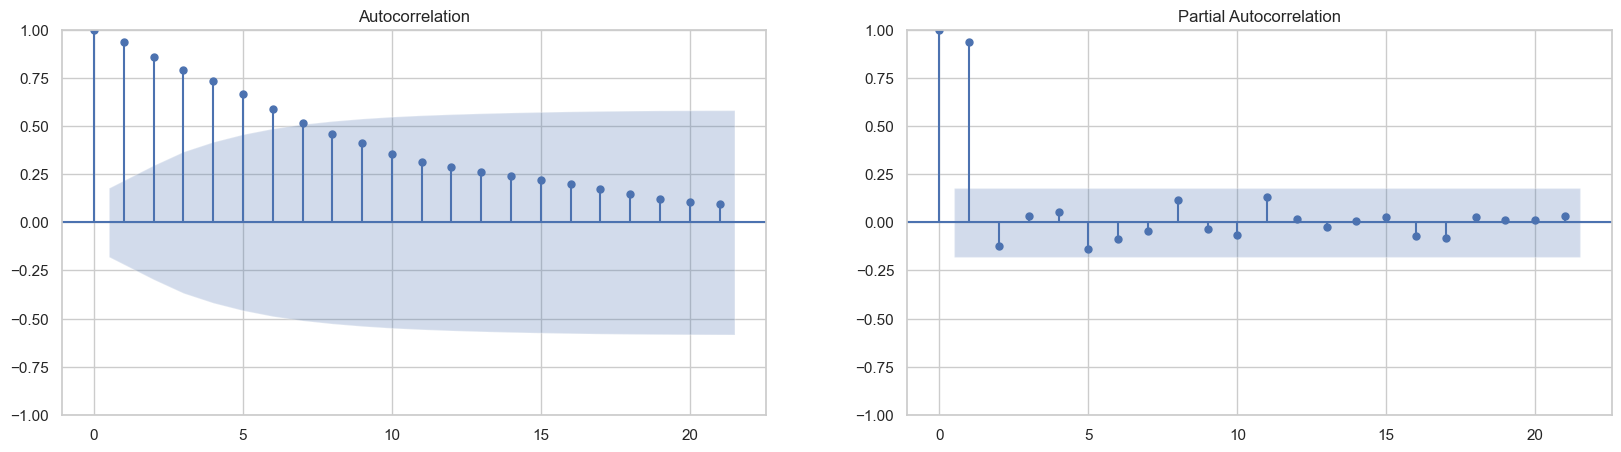

In [127]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
plot_acf(data_monthly.Close, ax=ax[0])  #Autocorrelation
plot_pacf(data_monthly.Close, ax=ax[1])  #Partial Autocorrelation
plt.show()

* PACF suggest p=2 (2 lags out of confidence interval)

### Stationarity tests
*  Augmented Dickey-Fuller (ADF) 
*  Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

In [128]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

adf_test(data_monthly.Close)

ADF Statistic: 1.7979798768127784
p-value: 0.9983450020284966
The series is not stationary.


In [129]:
data_monthly['Close_diff']=data_monthly['Close'].diff()

data_monthly['Close_diff']

Date
2015-01-31          NaN
2015-02-28     0.038765
2015-03-31     0.024998
2015-04-30    -0.006934
2015-05-31    -0.014494
                ...    
2024-08-31    -4.790168
2024-09-30    -2.059892
2024-10-31    19.272557
2024-11-30     8.185781
2024-12-31    -5.284523
Freq: M, Name: Close_diff, Length: 120, dtype: float64

In [130]:
adf_test(data_monthly['Close_diff'].dropna())

ADF Statistic: 0.976362868014379
p-value: 0.9940101814263073
The series is not stationary.


In [131]:
data_monthly['Close_diff_2']=data_monthly['Close_diff'].diff()

data_monthly['Close_diff_2']

Date
2015-01-31          NaN
2015-02-28          NaN
2015-03-31    -0.013767
2015-04-30    -0.031932
2015-05-31    -0.007560
                ...    
2024-08-31    -2.117304
2024-09-30     2.730276
2024-10-31    21.332449
2024-11-30   -11.086776
2024-12-31   -13.470305
Freq: M, Name: Close_diff_2, Length: 120, dtype: float64

In [132]:
adf_test(data_monthly['Close_diff_2'].dropna())

ADF Statistic: -3.9270516650478475
p-value: 0.0018445399326790077
The series is stationary.


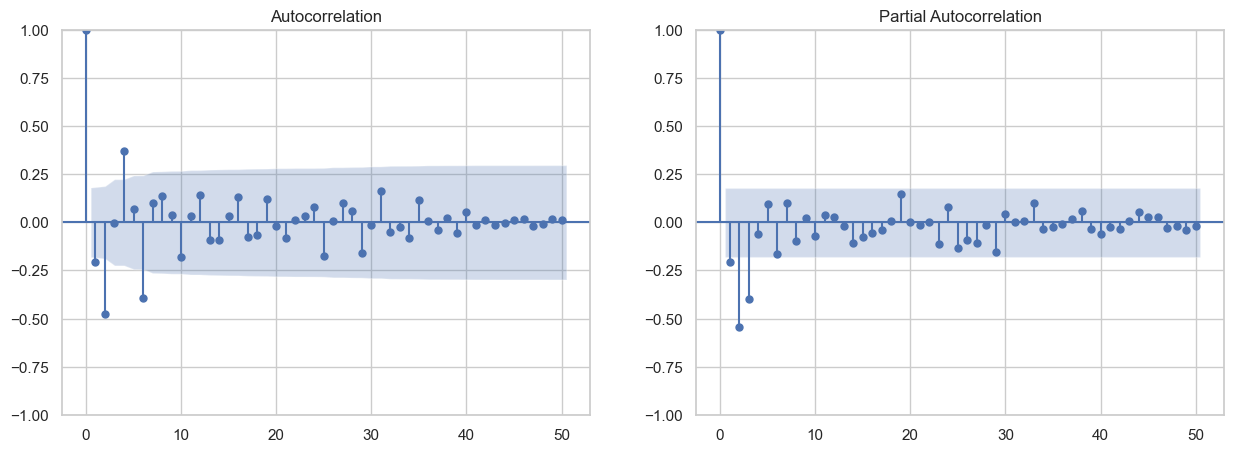

In [133]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot_acf(data_monthly['Close_diff_2'].dropna(),lags=50, ax=ax[0]) 
plot_pacf(data_monthly['Close_diff_2'].dropna(), lags=50, ax=ax[1])  
plt.show()

In [134]:
ts = data_monthly['Close_diff_2']

* AIC: Focuses on goodness-of-fit but penalizes model complexity (more params)
$$
\text{AIC} = 2k - 2\ln(\hat{L})
$$
* BIC: Similar to AIC but penalizes complexity more heavily than AIC
$$
\text{BIC} = k \ln(n) - 2\ln(\hat{L})
$$
&rarr; Lower values of AIC and BIC indicate a better fit, with a trade-off between model complexity and goodness-of-fit

In [135]:
p = range(0, 4) 
q = range(0, 4)  
d = 2  

pdq_combinations = list(itertools.product(p, [d], q))

best_aic = float("inf")
best_order = None
best_model = None

for order in pdq_combinations:
    try:
        model = sm.tsa.ARIMA(ts.dropna(), order=order).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order = order
            best_model = model
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

Best ARIMA order: (3, 2, 2) with AIC: 662.7598943257726


### Seasonal adjustments

In [136]:
data_monthly

Price,Close,High,Low,Open,Volume,Close_diff,Close_diff_2
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,
Date,,,,,,,
2015-01-31,0.476327,0.483228,0.470723,0.477863,2.070176e+08,NaN,NaN
2015-02-28,0.515092,0.518126,0.508634,0.513172,2.207126e+08,0.038765,NaN
2015-03-31,0.540091,0.546202,0.533224,0.539893,3.322929e+08,0.024998,-0.013767
2015-04-30,0.533157,0.537321,0.525722,0.530713,2.701739e+08,-0.006934,-0.031932
2015-05-31,0.518663,0.524200,0.512738,0.516911,3.540668e+08,-0.014494,-0.007560
...,...,...,...,...,...,...,...
2024-08-31,117.103732,119.962837,113.561098,116.806506,3.684258e+08,-4.790168,-2.117304
2024-09-30,115.043840,117.541563,112.602605,115.082833,3.136106e+08,-2.059892,2.730276


In [137]:
train = data_monthly.Close[:'2023-12']
 
test = data_monthly.Close['2024-01':]

In [138]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2015-01-31 to 2023-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NVDA    108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


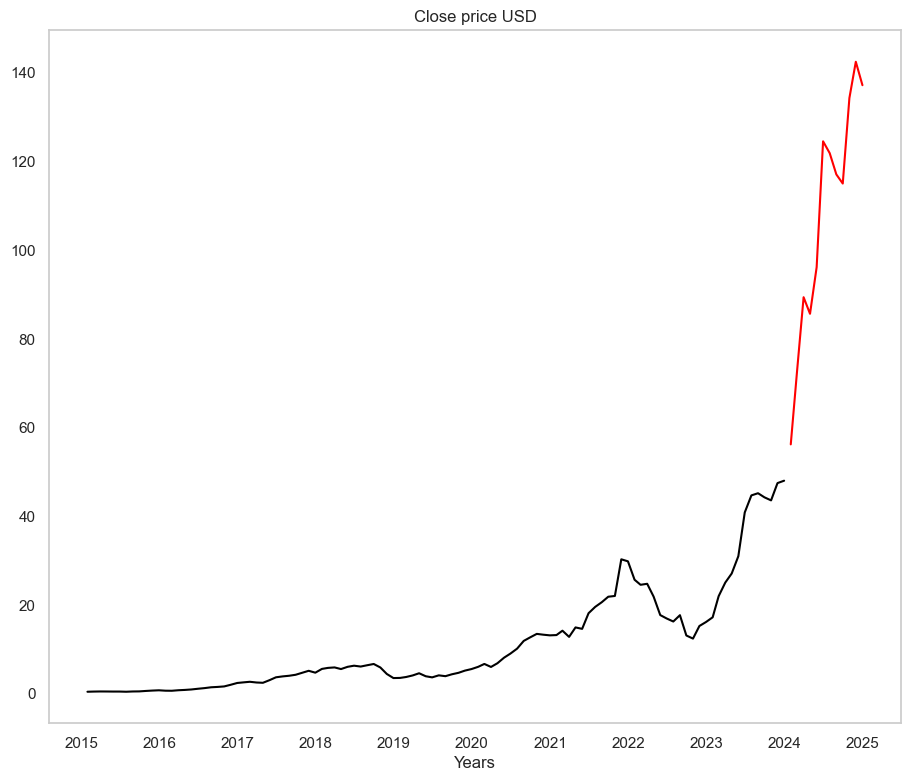

In [139]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Close price USD")
plt.xlabel('Years')
plt.grid()
 
plt.show()


* SARIMAX model simply adds a linear combination of exogenous variables to the SARIMA model.

##### SARIMAX on daily data : non-coverging constrained problem..



Unbounded Optimization Problem:
* (L-BFGS-B) optimiser is struggling because the parameter space is too wide or the initial conditions don’t make sense.
* Non-Stationary Data: used diff
* Seasonal Order : validating using fourrier
* Too Many Parameters:High-order ARIMA models (large p, q, P, Q) are computationally expensive and prone to overfitting.


In [140]:
model = SARIMAX(train.dropna(), 
                order = (3, 2, 2), 
                seasonal_order = (3, 2, 2, 12),
                enforce_stationarity = False, 
                enforce_invertibility = False)
 
result = model.fit(maxiter = 1000,
                    method = 'nm')

Optimization terminated successfully.
         Current function value: 1.280397
         Iterations: 778
         Function evaluations: 1631


In [141]:
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               NVDA   No. Observations:                  108
Model:             SARIMAX(3, 2, 2)x(3, 2, 2, 12)   Log Likelihood                -138.283
Date:                            Wed, 12 Feb 2025   AIC                            298.566
Time:                                    01:13:44   BIC                            317.939
Sample:                                01-31-2015   HQIC                           305.710
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3028   3.97e-19   7.63e+17      0.000       0.303       0.303
ar.L2         -0.7613   5.45e-19   -1.4e+18      0.000      -0.761      -0.761
ar.L3         -0.5873   2.57e-19  -2.29e+18      0.000      -0.587      -0.587
ma.L1         -1.2981   2.34e-19  -5.55e+18      0.000      -1.298      -1.298
ma.L2          1.0530   1.22e-18    8.6e+17      0.000       1.053       1.053
ar.S.L12      -1.5915   1.46e-19  -1.09e+19      0.000      -1.591      -1.591
ar.S.L24      -1.8747    2.5e-19  -7.48e+18      0.000      -1.875      -1.875
ar.S.L36      -0.4540   9.71e-20  -4.68e+18      0.000      -0.454      -0.454
ma.S.L12   -3.609e+12   3.32e-33  -1.09e+45      0.000   -3.61e+12   -3.61e+12
ma.S.L24    3.927e+12   3.05e-33   1.29e+45      0.000    3.93e+12    3.93e+12
sigma2      1.441e-24   2.89e-10   4.98e-15      1.000   -5.67e-10    5.67e-10
===================================================================================
Ljung-Box (L1) (Q):                   8.93   Jarque-Bera (JB):                 2.80
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):              17.09   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.11e+61. Standard errors may be unstable.
"""

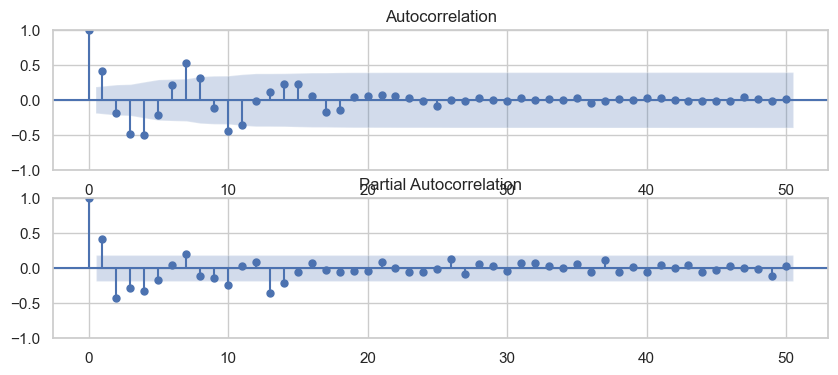

In [142]:
res = result.resid
fig,ax = plt.subplots(2,1,figsize=(10,4))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [2]:
# result.plot_diagnostics()


In [144]:
forecast = result.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [145]:
forecast_values, forecast_ci

(2024-01-31    48.891680
 2024-02-29    43.004446
 2024-03-31    32.553030
 2024-04-30    35.263653
 2024-05-31    39.084085
 2024-06-30    45.299138
 2024-07-31    41.507762
 2024-08-31    33.867171
 2024-09-30    32.941161
 2024-10-31    41.170597
 2024-11-30    62.961203
 2024-12-31    58.579392
 Freq: M, Name: predicted_mean, dtype: float64,
             lower NVDA  upper NVDA
 2024-01-31   38.408354   59.375006
 2024-02-29   27.607886   58.401006
 2024-03-31   13.680177   51.425882
 2024-04-30   13.168058   57.359249
 2024-05-31    9.939392   68.228778
 2024-06-30    4.565785   86.032490
 2024-07-31  -10.718397   93.733920
 2024-08-31  -26.223433   93.957776
 2024-09-30  -33.076666   98.958987
 2024-10-31  -33.048534  115.389728
 2024-11-30  -24.764813  150.687220
 2024-12-31  -44.681708  161.840493)

In [146]:
train, test

(Ticker           NVDA
 Date                 
 2015-01-31   0.476327
 2015-02-28   0.515092
 2015-03-31   0.540091
 2015-04-30   0.533157
 2015-05-31   0.518663
 ...               ...
 2023-08-31  45.233425
 2023-09-30  44.307441
 2023-10-31  43.618978
 2023-11-30  47.513827
 2023-12-31  48.056469
 
 [108 rows x 1 columns],
 Ticker            NVDA
 Date                  
 2024-01-31   56.243244
 2024-02-29   72.529888
 2024-03-31   89.421000
 2024-04-30   85.683636
 2024-05-31   96.197422
 2024-06-30  124.566763
 2024-07-31  121.893900
 2024-08-31  117.103732
 2024-09-30  115.043840
 2024-10-31  134.316398
 2024-11-30  142.502179
 2024-12-31  137.217656)

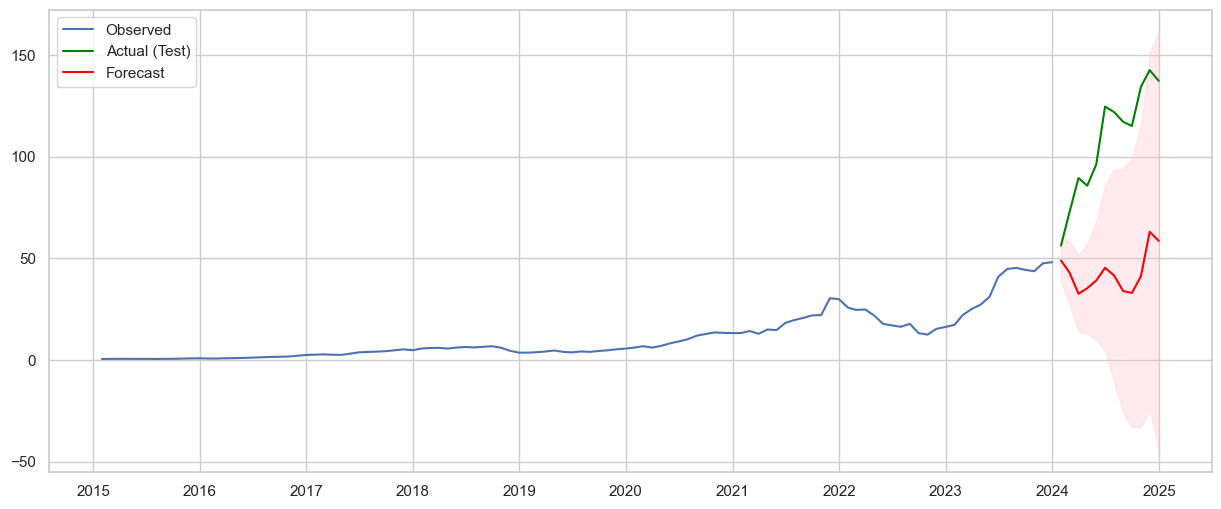

In [147]:
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Observed')
plt.plot(test.index, test, label='Actual (Test)', color='green')

plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')

plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0],  
                 forecast_ci.iloc[:, 1],  
                 color='pink', alpha=0.3)

plt.legend()
plt.show()

In [148]:
print(f"MSE = {mean_squared_error(test, forecast_values)} RMSE = {np.sqrt(mean_squared_error(test, forecast_values))}")

MSE = 4797.101435128643 RMSE = 69.26111055367683


###  Modeling Volatility clustering

**ARCH(q)** :

$$
\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \dots + \alpha_q \epsilon_{t-q}^2
$$


- $\sigma_t^2$: Conditional variance at time $t$.
- $\epsilon_t$: Residuals or error terms at time $t$.


**GARCH(p, q)**:

$$
\sigma_t^2 = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2
$$

With:
- $\sigma_{t-j}^2$: lagged variances (GARCH terms).




In [149]:
data_monthly['Log_Returns'] = np.log(data_monthly['Close'] / data_monthly['Close'].shift(1))
data_monthly


Price,Close,High,Low,Open,Volume,Close_diff,Close_diff_2,Log_Returns
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,,,
Date,,,,,,,,
2015-01-31,0.476327,0.483228,0.470723,0.477863,2.070176e+08,NaN,NaN,NaN
2015-02-28,0.515092,0.518126,0.508634,0.513172,2.207126e+08,0.038765,NaN,0.078241
2015-03-31,0.540091,0.546202,0.533224,0.539893,3.322929e+08,0.024998,-0.013767,0.047391
2015-04-30,0.533157,0.537321,0.525722,0.530713,2.701739e+08,-0.006934,-0.031932,-0.012922
2015-05-31,0.518663,0.524200,0.512738,0.516911,3.540668e+08,-0.014494,-0.007560,-0.027562
...,...,...,...,...,...,...,...,...
2024-08-31,117.103732,119.962837,113.561098,116.806506,3.684258e+08,-4.790168,-2.117304,-0.040091
2024-09-30,115.043840,117.541563,112.602605,115.082833,3.136106e+08,-2.059892,2.730276,-0.017747


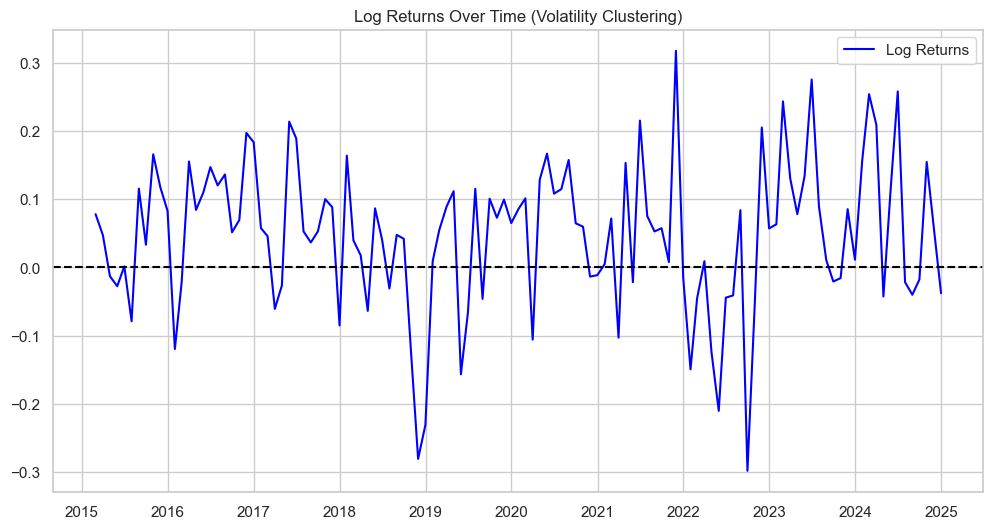

In [150]:

plt.figure(figsize=(12, 6))
plt.plot(data_monthly.index, data_monthly['Log_Returns'], label="Log Returns", color='blue')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Log Returns Over Time (Volatility Clustering)")
plt.legend()
plt.show()


In [154]:
arch_test = het_arch(data_monthly['Log_Returns'].dropna())


(4.926246454966461,
 0.8960500115943962,
 0.46387502722078167,
 0.9093990616576941)

* volatility dependence: p-value = 0.8960  &rarr; volatility do not cluster ! &rarr; var of log returns is cte over time (homoskedastic).

In [161]:

garch_model = arch_model(data_monthly['Log_Returns'].dropna(), vol='Garch', p=1, q=1)
garch_fit = garch_model.fit()

print(garch_fit.summary())


Iteration:      1,   Func. Count:      6,   Neg. LLF: 637.9171751860755
Iteration:      2,   Func. Count:     15,   Neg. LLF: 536.8339502152827
Iteration:      3,   Func. Count:     24,   Neg. LLF: 12388.761653571917
Iteration:      4,   Func. Count:     31,   Neg. LLF: -95.81224532682134
Iteration:      5,   Func. Count:     36,   Neg. LLF: -96.05161211012887
Iteration:      6,   Func. Count:     41,   Neg. LLF: -95.71584656110103
Iteration:      7,   Func. Count:     47,   Neg. LLF: -96.11845807357957
Iteration:      8,   Func. Count:     53,   Neg. LLF: -94.5731791783115
Iteration:      9,   Func. Count:     60,   Neg. LLF: -96.59610858327511
Iteration:     10,   Func. Count:     65,   Neg. LLF: -96.5998242695492
Iteration:     11,   Func. Count:     70,   Neg. LLF: -96.60019998182554
Iteration:     12,   Func. Count:     75,   Neg. LLF: -96.60022147080659
Iteration:     13,   Func. Count:     80,   Neg. LLF: -96.60022282350064
Iteration:     14,   Func. Count:     84,   Neg. LLF: -